# HW3: Feature Matching and Snakes



In this homework assignment, we will see how to use snakes to segment images and how to match features between images

In [278]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import requests
import skimage.io

%matplotlib inline

## Feature Matching

Load the exercise images:

In [279]:
im1 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1y8eKxsxxQDDxnwZex_qNi_1QtEmr7xai").content, np.uint8), cv2.IMREAD_GRAYSCALE)
im2 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1ZRNAyo9SUeL0BcTJKFzKuEku2-YTkvA9").content, np.uint8), cv2.IMREAD_GRAYSCALE)
im3 = cv2.imdecode(np.frombuffer(requests.get("https://drive.google.com/uc?id=1DPGLB1NtZiPEhSVHnVq_1yc5d5XSCEjf").content, np.uint8), cv2.IMREAD_GRAYSCALE)

Make sure the download worked

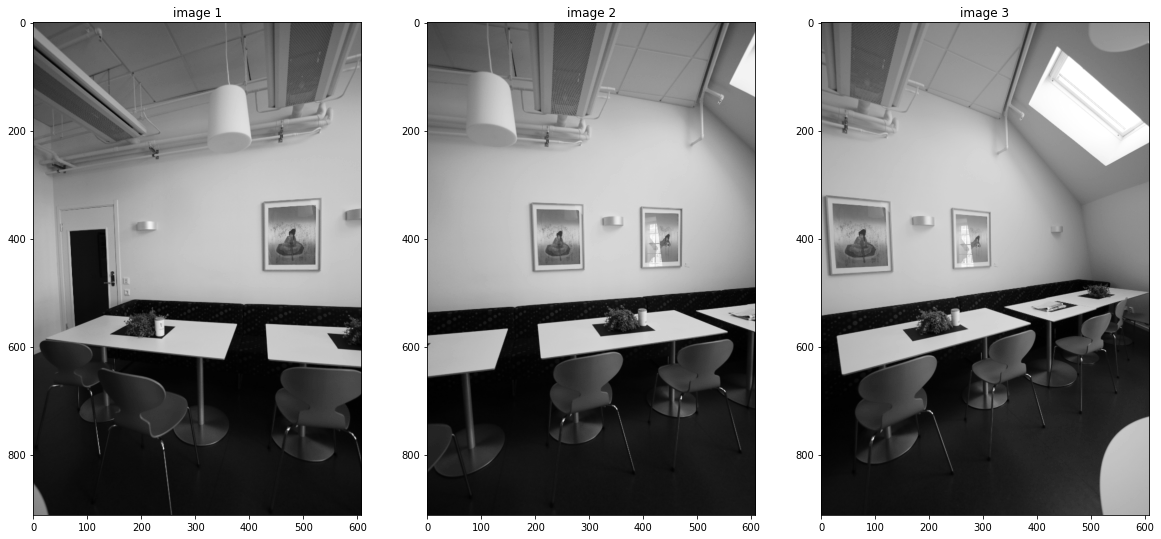

In [280]:
plt.figure(figsize=(20,10))
plt.subplot(131),plt.imshow(im1, cmap='gray'),plt.title('image 1')
plt.subplot(132),plt.imshow(im2, cmap='gray'),plt.title('image 2')
plt.subplot(133),plt.imshow(im3, cmap='gray'),plt.title('image 3');

Use image 1 and image 2

Extract SIFT keypoints and descriptors from both images (`cv2.xfeatures2d.SIFT_create()` and `.detectAndCompute()`).

Match the descriptors (2-nn) and apply the ratio test (`cv2.BFMatcher_create` and `.knnMatch()`)

Show the matching before and after the ratio test (`cv2.drawMatchesKnn`)

In [301]:
# TODO: your code here

# extract SIFT features from the images im1 and im2
# hint: 
#mask = np.ones(im1.shape, np.uint8)
sift = cv2.SIFT_create()
kpts1, desc1 = sift.detectAndCompute(im1, None)
kpts2, desc2 = sift.detectAndCompute(im2, None)
#print(kpts1.queryIdx)
#print(kpts1)
# match features using Brute Force matcher, e.g. cv2.BFMatcher_create() and cv2.BFMatcher.knnMatch()
BFer = cv2.BFMatcher_create()
print(desc1)
matches = BFer.knnMatch(desc1,desc2,2)
#print(matches)
# Apply ratio test with 0.75 difference factor
good = []
ratio = 0.75
for m,n in matches:
    
    # check if the distance between the two matches is less than 0.75 times the distance of the best match
    # if so, append the match to the "good" list
    # hint: use m.distance and n.distance
    
    if m.distance < ratio * n.distance:
        good.append([m])    
        
        
# for future use in the next question, align the "good" points in two arrays
# TODO: your code here
# hint: use np.array([[0,0]]*len(good)), this will create an array of zeros with the same length as the "good" list
# you will need two arrays, one for the points in image 1 (e.g. pts1) and one for the points in image 2 (e.g. pts2)
# then, for each match in the "good" list, use the .queryIdx and .trainIdx to get the corresponding points
# and append them to the corresponding array, e.g. pts1[i] = kpts1[match[0].queryIdx].pt
# use enumerate(good) to get the index i and the match in each iteration
# use .pt to get the actual point, and use i to put the point in the correct index in the pts1 and pts2 array
pts1 = np.array([[0,0]]*len(good))
pts2 = np.array([[0,0]]*len(good))
for i, match in enumerate(good):
    #print(match[0])
    pts1[i] = kpts1[match[0].queryIdx].pt
    pts2[i] = kpts2[match[0].trainIdx].pt

[[ 19.  20.   0. ...   1.   1.   0.]
 [ 25. 105.  33. ...   4.   3.   0.]
 [ 38.   1.   0. ...   1.   0.   0.]
 ...
 [ 70.  19.   3. ...  20.   5.  17.]
 [ 52.  69.   7. ...  13.   9.  76.]
 [  4.   4.   0. ...  13.  11.   4.]]


This is how it should look like:

(<AxesSubplot: title={'center': 'ratio test'}>,
 Text(0.5, 1.0, 'ratio test'))

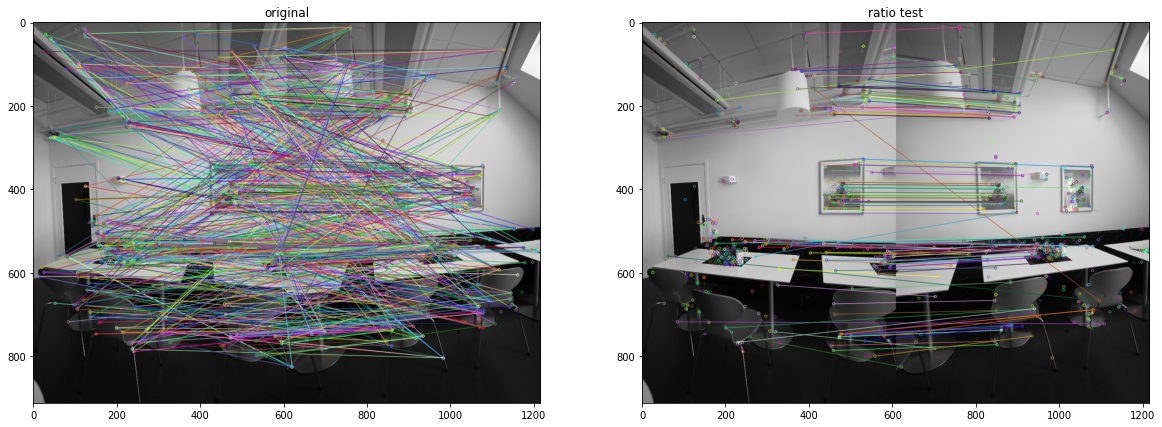

In [282]:
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,matches,im1.copy())), plt.title('original')
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title('ratio test')

In [283]:
# apply the reciprocity test to the "good" matches to remove outliers (see lecture slides)
#your code here
# for reciprocity, we need to test the matches from desc2 to desc1 using bf.knnMatch(desc2, desc1, 2)
# then, for each match in the "good" list, we need to check if the match from desc2 to desc1 is also in the "good" list
# if so, append the match to the "good_reciprocal" list
# hint: use the .queryIdx and .trainIdx to get the corresponding points
# use enumerate(good) to get the index i and the match in each iteration
# use .pt to get the actual point, and use i to put the point in the correct index in the pts1 and pts2 array
BFer2 = cv2.BFMatcher_create()
matches2 = BFer2.knnMatch(desc2,desc1,2)
good_reciprocal = []
for i, good_match in enumerate(good):
    #print(kpts2[good_match[0].trainIdx].pt)
    # good_match is a match from desc1 to desc2, so we need to check in the reciprocal matches if there is a match from desc2 to desc1
    
    for reciprocal_match, _ in matches2:
        #print(reciprocal_match.trainIdx)
        #print(kpts1[good_match[0].queryIdx].pt)
        #print(kpts2[reciprocal_match.trainIdx].pt)
        # check if the queryIdx of the reciprocal match is the same as the trainIdx of the good match
        # and if the trainIdx of the reciprocal match is the same as the queryIdx of the good match
        #print(pts1[i])
       # print(kpts1[good_match[0].queryIdx].pt)
       # print(kpts1[reciprocal_match.trainIdx].pt)
       #good matches from image 1 with reciprocal matches from image 1, 
       #good matches from image 2 with reciprocal matches from image 2, 
        if (good_match[0].queryIdx == reciprocal_match.trainIdx) and (good_match[0].trainIdx == reciprocal_match.queryIdx):
            good_reciprocal.append(good_match)
            #print(good_match)

print(len(good_reciprocal))
# for future use in the next question, align the "good_reciprocal" points in two arrays
# use np.array([[0,0]]*len(good_reciprocal)) again to create the 2 arrays
pts1 = np.array([[0,0]]*len(good_reciprocal)) 
pts2 = np.array([[0,0]]*len(good_reciprocal)) 
for i, match in enumerate(good_reciprocal):
    pts1[i] = kpts1[match[0].queryIdx].pt
    pts2[i] = kpts2[match[0].trainIdx].pt

141


(<AxesSubplot: title={'center': 'Reciprocal: 141'}>,
 Text(0.5, 1.0, 'Reciprocal: 141'))

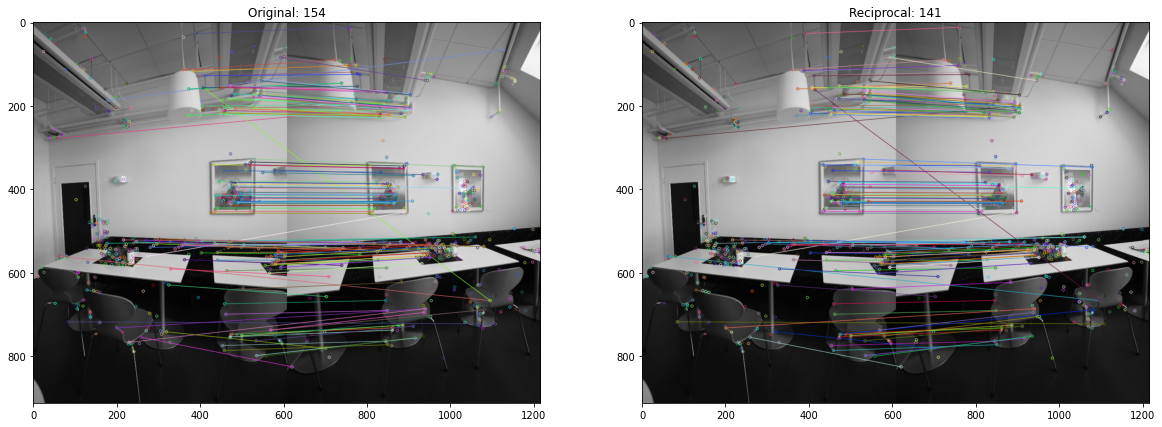

In [284]:
# show the matching results, use cv2.drawMatchesKnn to draw the matches in the good and good_reciprocal lists, side by side
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title('Original: ' + str(len(good)))
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good_reciprocal,im1.copy())), plt.title('Reciprocal: ' + str(len(good_reciprocal)))

We were able to get a little bit more specificity in our matching, which is always a good thing.

## Geometric Model Fitting

Given the above matching (make sure you keep the `good` variable!)


### Affine transform

Find an affine transform using Linear Least Squares by solving a $Ax=0$ equation (use `np.linalg.svd`) and show the resulting warping (`cv2.warpAffine`).

Let $p_i^{(1)}=(x_i^{(1)},y_i^{(1)})$ and $p_i^{(2)}=(x_i^{(2)},y_i^{(2)})$ be matching points in images 1 and 2 respectively, recall:

$$
Mp_i^{(1)} =
\begin{pmatrix}
a & b & t_x \\
c & d & t_y \\
\end{pmatrix}
\begin{pmatrix}
x_i^{(1)} \\ y_i^{(1)} \\ 1
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
x_i^{(2)} \\ y_i^{(2)} 
\end{pmatrix}
= p_i^{(2)}
$$

So we would like to minimize the following functor

$$
E_\mathrm{affine}(P_{n}^{(1)},P_{n}^{(2)}) = \sum_i^n || Mp_i^{(1)} - p_i^{(2)} ||
$$

In terms of $M$, e.g.
$$
\hat{M} = \arg\min_{M} E_\mathrm{affine}(P_{n}^{(1)},P_{n}^{(2)})
$$

Expand the multiplication:
$$
x_i^{(2)} = ax_i^{(1)} + by_i^{(1)} + t_x\\
y_i^{(2)} = cx_i^{(1)} + dy_i^{(1)} + t_y
$$

We construct a system of equations of shape $Ax=b$:
$$
\begin{pmatrix}
& \cdots & \\ 
x_i^{(1)} & y_i^{(1)} & 1 & 0 & 0 & 0 \\
0 & 0 & 0 & x_i^{(1)} & y_i^{(1)} & 1 \\
& \cdots & 
\end{pmatrix}
\begin{pmatrix}
a \\ b \\ t_x \\ c \\ d \\ t_y
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
\cdots \\ x_i^{(2)} \\ y_i^{(2)} \\ \cdots 
\end{pmatrix}
$$

---

In [285]:
# linear least squares solution for finding an affine trasformation matrix
def findAffineLLSQ(ptsLeft, ptsRight):
    # create the A matrix, which is a 2n x 6 matrix, where n is the number of points
    # use np.repeat to create a 2n x 6 matrix of zeros (np.zeros) with the same length as the number of points (len(ptsLeft))
    # hint: don't forget to use np.float32 to create the matrix and axis=0 to repeat as rows
    
    A = np.zeros((2*len(ptsLeft),6), np.float32)#np.repeat( , , axis = 0)
    
    
    ##create a b vector, which is a 2n x 1 vector (column vector) of zeros (np.zeros) with the same length as the A matrix rows (len(A))
    b = np.zeros((len(A),1), np.float32)
    for i in range(len(ptsLeft)):
        # populate the A matrix
        # hint: use the ptsLeft and ptsRight arrays to get the points, and use the i index to put the points in the correct row
        # e.g. x,y = ptsLeft[i] will give you the left point, and x,y = ptsRight[i] will give you the right point
        
        xil,yil = ptsLeft[i]
        xir,yir = ptsRight[i]

        # according to the guidance above, we need to populate the A matrix with the following two rows for each point:
        # [xil,yil,1,0,0,0]
        # [0,0,0,xil,yil,1]
        # the row index can be figured out using the i index
        A[2*i, :] = [xil,yil,1,0,0,0]
        A[2*i + 1, :] = [0,0,0,xil,yil,1]

        # populate the b vector with the following two rows for each point:
        # [xir]
        # [yir]
        # the row index can be figured out using the i index
        b[2*i] = [xir]
        b[2*i+1] = [yir]

    # use np.linalg.lstsq to solve the linear system of equations
    #print(len(ptsLeft))
    #print(A.shape)
    #print(b.shape)
    
    result = np.linalg.lstsq(A,b,rcond=None)
    #print(result[0].shape)
    # the result will be a 6x1 vector, which we need to reshape to a 2x3 matrix
    # hint: use np.reshape((2,3))
    # return the result
    return np.reshape(result[0],(2,3))


In [286]:
# a utility for warping and blending images using an affine transformation matrix
def warpAndblendImagesAffine(image1,image2,M):
    h_,w_ = image1.shape
    im2warp = cv2.warpAffine(image2, M, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    im2mask = cv2.warpAffine(np.ones_like(image2), M, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    return image1 * (1.0 - im2mask) + im2warp * im2mask

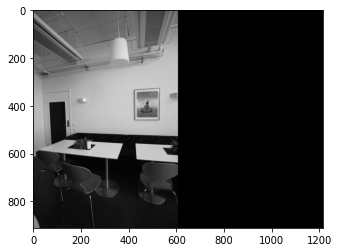

In [287]:
# make a copy of image 1 with room on the right for image 2
im1wide = np.hstack([im1, np.zeros_like(im1)])

# display the im1wide image
plt.imshow(im1wide, cmap='gray')

[[ 2.0012304e-01  9.9137738e-02  1.2282302e+02]
 [-3.6624204e-02  9.3272591e-01  4.7680122e+01]]


(<AxesSubplot: title={'center': 'im1 transformed'}>,
 Text(0.5, 1.0, 'im1 transformed'))

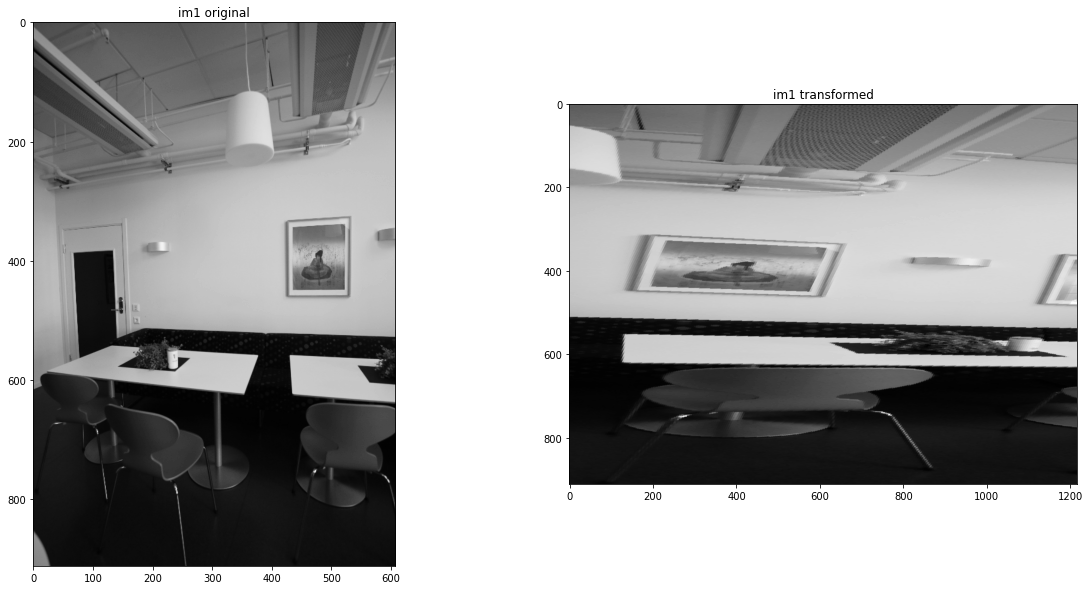

In [288]:
# use the findAffineLLSQ function you wrote to find the affine transformation matrix between the two images
# using the pts1 and pts2 arrays
M = findAffineLLSQ(pts1,pts2)
print(M)

# show the result using warpAndBlendImagesAffine side by side with the original image
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(im1, cmap='gray'), plt.title('im1 original')
plt.subplot(122),plt.imshow(warpAndblendImagesAffine(im1wide,im2, M), cmap='gray'), plt.title('im1 transformed')

This is looking pretty bad. Not even close!

Let's try OpenCV's method that can apply the RANSAC method for eliminating outliers

In [289]:
# use cv2.estimateAffine2D to find the affine transformation matrix using the pts1 and pts2 arrays
# RANSAC will be the default method
M, mask = cv2.estimateAffine2D(pts1,pts2)

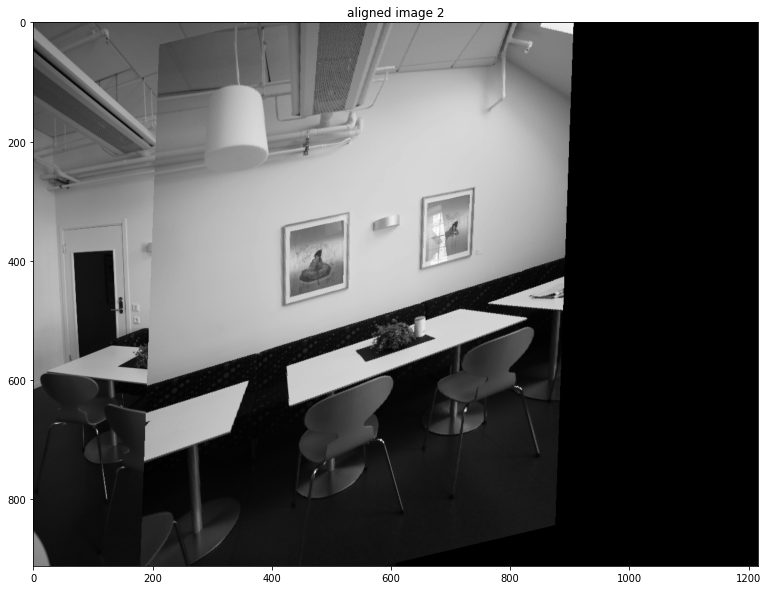

In [290]:
plt.figure(figsize=(20,10))
plt.imshow(warpAndblendImagesAffine(im1wide, im2, M), cmap='gray'), plt.title('aligned image 2');

Eeef . Still pretty bad. 

Let's look at which point-pairs have survived the affine RANSAC:

(<AxesSubplot: title={'center': 'Masked: 40'}>,
 Text(0.5, 1.0, 'Masked: 40'))

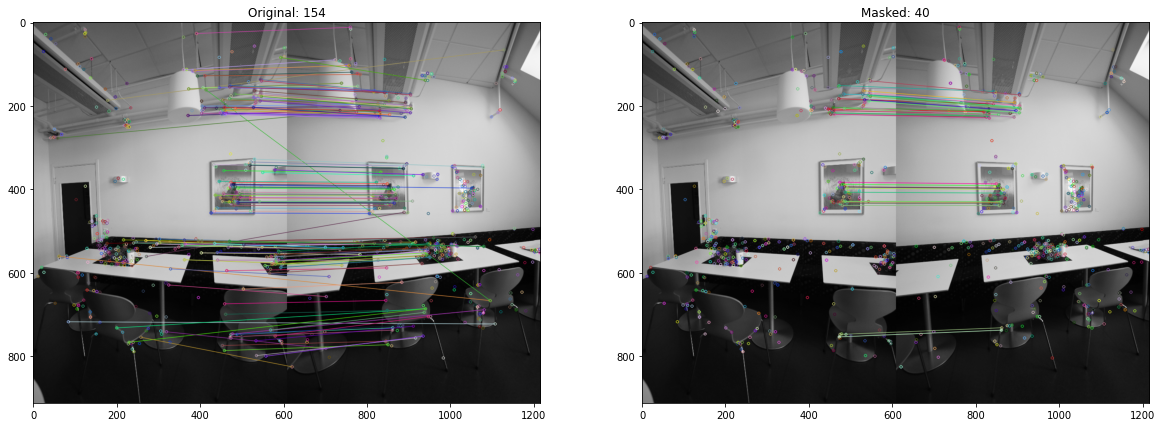

In [291]:
# prune the matches using the mask
# hint: use a list comprehension [... for ...] to create a new list of matches that are in the mask
# hint: use `for i in range(len(mask))` and `if mask[i] == 1`
good_masked = [good_reciprocal[i] for i in range(len(mask)) if mask[i] == 1]
#For each item in the reciprocal test, we only let it through if that mask = 1

# show the masked matchings between the two images side by side with the original matchings (good)
# using the cv2.drawMatchesKnn function and the good and good_masked lists
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title('Original: ' + str(len(good)))
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good_masked,im1.copy())), plt.title('Masked: ' + str(len(good_masked)))

Very little points. No wonder, the affine transformation is not a good fit for this problem. We need to find a homography

### Homography

Find a homography using unconstrained Linear Least Squares by solving a $AX=0$ equation, and show the resulting homography warping (`cv2.warpPerspective`).

Consider $p_i^{(1)}=(x_i^{(1)},y_i^{(1)})$ and $p_i^{(2)}=(x_i^{(2)},y_i^{(2)})$ our matching points. 

We can formulate the problem as such:
$$
\begin{pmatrix}
h_1 & h_2 & h_3 \\
h_4 & h_5 & h_6 \\
h_7 & h_8 & h_9
\end{pmatrix}
\begin{pmatrix}
x_i^{(1)} \\ y_i^{(1)} \\ 1
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\lambda
\begin{pmatrix}
x_i^{(2)} \\ y_i^{(2)} \\ 1
\end{pmatrix}
=
\begin{pmatrix}
\lambda x_i^{(2)} \\ \lambda y_i^{(2)} \\ \lambda
\end{pmatrix}
\,\,\,,\,\,\,
\hat{x_i^{(2)}} = x_i^{(2)} / \lambda\,\,\,, \,\,\,
\hat{y_i^{(2)}} = y_i^{(2)} / \lambda
$$
$$
\hat{x_i^{(2)}} = \frac{h_1x_i^{(1)}+h_2y_i^{(1)}+h_3}{h_7x_i^{(1)}+h_8y_i^{(1)}+h_9}
\,\,\,, \,\,\,
\hat{y_i^{(2)}} = \frac{h_4x_i^{(1)}+h_5y_i^{(1)}+h_6}{h_7x_i^{(1)}+h_8y_i^{(1)}+h_9}
$$
$$
h_7\hat{x_i^{(2)}}x_i^{(1)}+h_8\hat{x_i^{(2)}}y_i^{(1)}+h_9\hat{x_i^{(2)}} - h_1x_i^{(1)} - h_2y_i^{(1)} - h_3 = 0\\
h_7\hat{y_i^{(2)}}x_i^{(1)}+h_8\hat{y_i^{(2)}}y_i^{(1)}+h_9\hat{y_i^{(2)}} - h_4x_i^{(1)} - h_5y_i^{(1)} - h_6 = 0
$$
And thus:
$$
\begin{pmatrix}
& \cdots & \\
-x_i^{(1)} & -y_i^{(1)} & -1 & 0 & 0 & 0 & \hat{x_i^{(2)}}x_i^{(1)} & \hat{x_i^{(2)}}y_i^{(1)} & \hat{x_i^{(2)}} \\
0 & 0 & 0 & -x_i^{(1)} & -y_i^{(1)} & -1 & \hat{y_i^{(2)}}x_i^{(1)} & \hat{y_i^{(2)}}y_i^{(1)} & \hat{y_i^{(2)}}  \\
& \cdots & 
\end{pmatrix}
\begin{pmatrix}
h_1 \\ h_2 \\ h_3 \\
h_4 \\ h_5 \\ h_6 \\
h_7 \\ h_8 \\ h_9
\end{pmatrix}
\mathop{=}_{\mathrm{should}}
\begin{pmatrix}
\cdots \\ 0 \\ 0 \\ \cdots 
\end{pmatrix}
$$

In [292]:
# a utility for warping and blending images using a homography matrix
def warpAndblendImagesHomography(image1,image2,H):
    h_,w_ = image1.shape
    im2warp = cv2.warpPerspective(image2, H, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    im2mask = cv2.warpPerspective(np.ones_like(image2), H, (w_,h_), flags=cv2.WARP_INVERSE_MAP, borderMode=cv2.BORDER_CONSTANT)
    return image1 * (1.0 - im2mask) + im2warp * im2mask

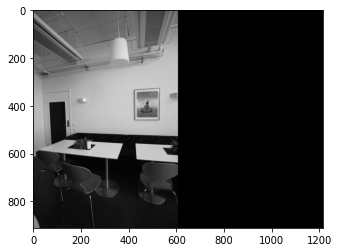

In [293]:
# make a copy of image 1 with room on the right for image 2
im1wide = np.hstack([im1, np.zeros_like(im1)])

# display the im1wide image
plt.imshow(im1wide, cmap='gray')

Implement and Run the LLSQ method for finding homography

In [ ]:
# homogeneous linear least squares solution for finding a homography
def findHomographyLLSQ(ptsLeft, ptsRight):
    # create the A matrix, which is a 2n x 9 matrix, where n is the number of points
    # use np.repeat to create a 2n x 9 matrix of zeros (np.zeros) with the same length as the ptsLeft array
    A = np.zeros((2*len(ptsLeft),9), np.float32)
    
    
    for i in range(len(ptsLeft)):
        # populate the A matrix
        # hint: use the ptsLeft and ptsRight arrays to get the points, and use the i index to put the points in the correct row
        # e.g. x,y = ptsLeft[i] will give you the left point, and x,y = ptsRight[i] will give you the right point
        
        xil,yil = ptsLeft[i]
        xir,yir = ptsRight[i]

        # according to the guidance above, we need to populate the A matrix with the following two rows for each point:
        #  [-xL -yL -1 0 0 0 xR*xL xR*yL xR]
        #  [0 0 0 -xL -yL -1 yR*xL yR*yL yR]
        # the row index can be figured out using the i index
        A[2*i, :] = [-xil, -yil, -1, 0, 0, 0, xir*xil, xir*yil, xir]  
        A[2*i + 1, :] = [0, 0, 0, -xil, -yil, -1, yir*xil, yir*yil, yir]

    # take the SVD of A (`np.linalg.svd`) and pick the last row of Vt (last column of V)
    # your code here...
    u,z,vt = np.linalg.svd(A)
    #print(vt[-1,:].shape)
    vectorSolution = vt[-1,:]
    # the last row of Vt is the solution to the homogeneous (Ax=0) linear least squares problem
    # reshape the vector back to a 3,3 matrix
    H = np.reshape(vectorSolution, (3,3))
    # normalize the last element to 1 (homogeneous coordinates) by dividing H by the last [2,2] element of H
    return H/H[2,2]

In [ ]:
# use the findHomographyLLSQ function you wrote to find the homography matrix
# using the pts1 and pts2 arrays
H = findHomographyLLSQ(pts1,pts2)
print(H)
# get the result using warpAndBlendImagesHomography
lstsqWarp = warpAndblendImagesHomography(im1,im2,H)

[[-8.7152761e-01 -1.4693297e-01  3.9205191e+02]
 [-1.3150151e+00 -4.2970818e-01  6.6641156e+02]
 [-2.3409221e-03 -4.2034721e-04  1.0000000e+00]]


Now find a homography using RANSAC (`M, mask = cv2.findHomography`), show only the inliers pair-matches that survived RANSAC as well as the final warping

In [ ]:
# use the cv2.findHomography function to find the homography matrix, and use the cv2.RANSAC as the method
H, mask = cv2.findHomography(pts1,pts2,cv2.RANSAC)
print(H)
# use the warpAndblendImagesHomography function to warp and blend the images
findHomogWarp = warpAndblendImagesHomography(im1,im2,H)

[[ 2.25288465e+00  6.88030137e-02 -6.20033513e+02]
 [ 8.46456257e-01  1.87469915e+00 -3.59171669e+02]
 [ 2.01151853e-03  3.00462267e-05  1.00000000e+00]]


Display the results

(<AxesSubplot: title={'center': 'cv2.findHomogWarp'}>,
 Text(0.5, 1.0, 'cv2.findHomogWarp'))

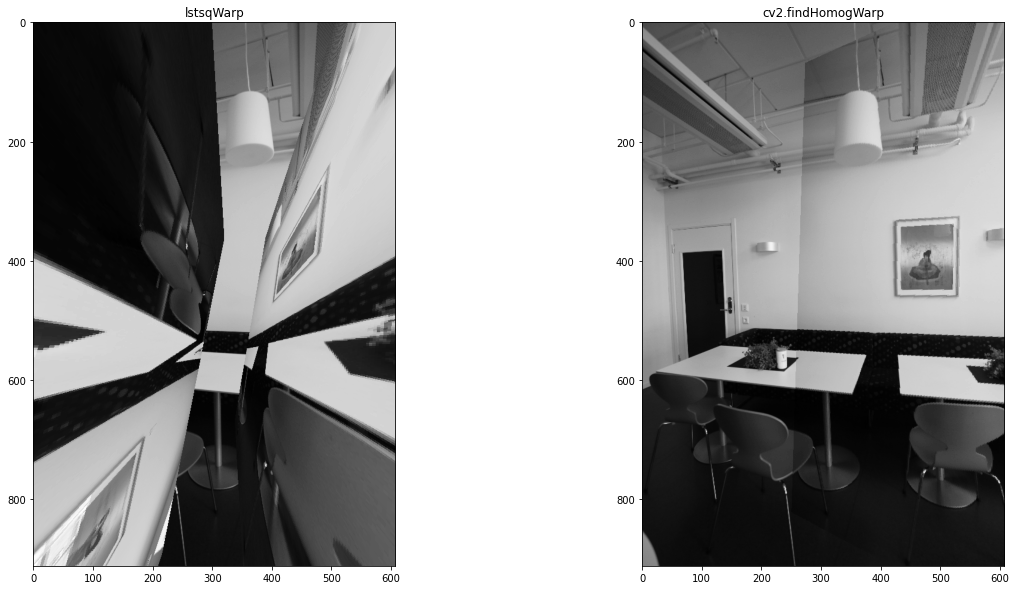

In [ ]:
# show the lstsqWarp and findHomogWarp images side by side for comparison
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(lstsqWarp, cmap='gray'), plt.title('lstsqWarp')
plt.subplot(122),plt.imshow(findHomogWarp, cmap='gray'), plt.title('cv2.findHomogWarp')

What was the method that produced the best (valid) image alignment result?

In [ ]:
# The cv2.findHomogWarp because this method implemented RANSAC which got rid of
# our "Devistating" outliers, while our method did not

It seems that even a small proportion of outliers in the matching can cause *devastating* results.

Remember that we have the `mask` of inlier points that were included in the final homography calculation

(<AxesSubplot: title={'center': 'Masked: 102'}>,
 Text(0.5, 1.0, 'Masked: 102'))

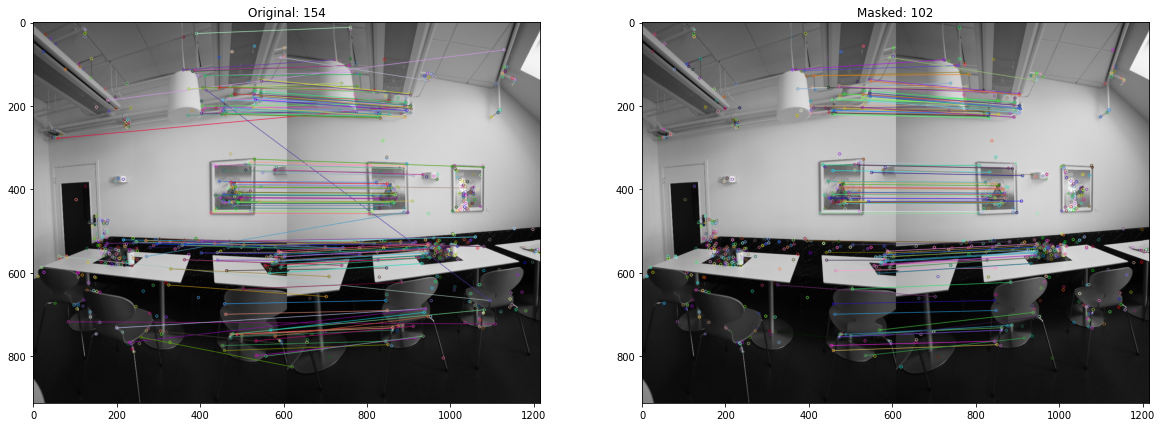

In [ ]:
# prune the matches with the `mask` using the same method as above
good_masked = [good_reciprocal[i] for i in range(len(mask)) if mask[i] == 1]
#For each item in the reciprocal test, we only let it through if that mask = 1

# show the masked matchings between the two images side by side with the original matchings (good)
# using the cv2.drawMatchesKnn function and the good and good_masked lists
plt.figure(figsize=(20,10))
plt.subplot(121),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good,im1.copy())), plt.title('Original: ' + str(len(good)))
plt.subplot(122),plt.imshow(cv2.drawMatchesKnn(im1,kpts1,im2,kpts2,good_masked,im1.copy())), plt.title('Masked: ' + str(len(good_masked)))

# show the masked matchings between the two images (the ones that were used to find the homography)
# using the cv2.drawMatchesKnn function and the good_masked list
# show the "good" matches and the "good_masked" matches side by side in a 1x2 subplot
# plt.figure(...

try running `findHomographyLLSQ` again with the mask:

[[ 2.2710433e+00  6.8686396e-02 -6.2576227e+02]
 [ 8.5856646e-01  1.8854517e+00 -3.6454236e+02]
 [ 2.0364334e-03  2.9622792e-05  1.0000000e+00]]


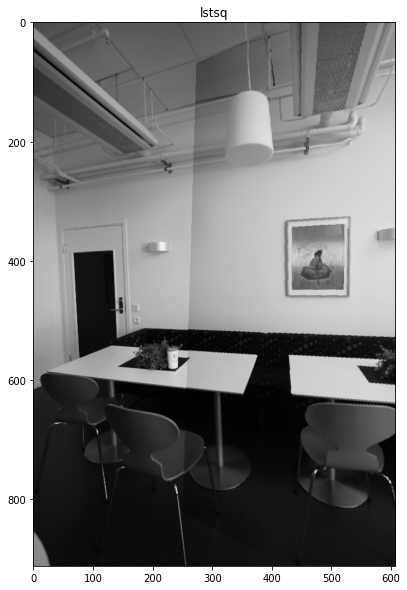

In [ ]:
# apply the mask to the points to get the inliers (the points that were used to find the homography)
# by using the mask to index into the pts1 and pts2 arrays, e.g. pts1[mask[:,0]==1]

H = findHomographyLLSQ(pts1[mask[:,0]==1],pts2[mask[:,0]==1])
print(H)
# warp and blend the images using the homography matrix using the warpAndblendImagesHomography function
lstsqWarp = warpAndblendImagesHomography(im1,im2,H)
plt.figure(figsize=(20,10))
plt.imshow(lstsqWarp, cmap='gray'), plt.title('lstsq');

Is it looking better now? :)

## Snakes

Let's load our class favorite - the seagull image.
We will attempt to segment its eye using a simple active contour - a "snake" like we've seen in class.

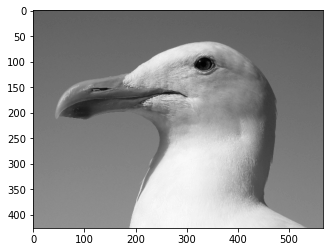

In [ ]:
# load the image from the url https://upload.wikimedia.org/wikipedia/commons/9/9a/Gull_portrait_ca_usa.jpg using skimage.io.imread
# and convert it to grayscale
url = 'https://upload.wikimedia.org/wikipedia/commons/9/9a/Gull_portrait_ca_usa.jpg' #use url for global implementation
filename = 'Seagull.jpg'
im1 = skimage.io.imread(filename)
im1 = skimage.color.rgb2gray(im1)
# scale down the image to 1/4 of its original size using cv2.resize
im1 = cv2.resize(im1, (0,0), fx=0.25, fy=0.25)

# show the image
plt.imshow(im1, cmap='gray')

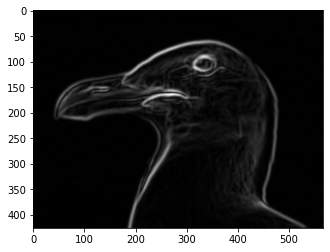

In [ ]:
# find the gradient magnitude using the cv2.Sobel function (use the cv2.CV_64F datatype) in both x and y directions
# and the cv2.magnitude function to get the magnitude
# use a kernel size of 25
ksize = 25
dx = cv2.Sobel(im1, ddepth=cv2.CV_64F, dx = 1, dy = 0, ksize=ksize)
dy = cv2.Sobel(im1, ddepth=cv2.CV_64F, dx = 0, dy = 1, ksize=ksize)
mag = cv2.magnitude(dx,dy)

# show the gradient magnitude image
plt.imshow(mag, cmap='gray')

(150.0, 60.0)

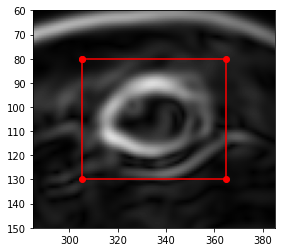

In [ ]:
# consider a rectangular curve around the gull's eye
# (adding the first point to the end of the curve to close the curve)
curve = np.array([[305, 80], [365, 80], [365, 130], [305, 130], [305, 80]], np.float32)

# show the image with the curve 
plt.imshow(mag, cmap='gray')
plt.plot(curve[:,0], curve[:,1], 'r-')
plt.scatter(curve[:,0], curve[:,1], c='r')
# crop the figure to the bounding box of the curve
plt.xlim(curve[:,0].min() - 20, curve[:,0].max() + 20)
plt.ylim(curve[:,1].max() + 20, curve[:,1].min() - 20)

In [ ]:
# calculate the arc distance for each point in the curve (use the np.diff function)
# and the np.cumsum function
# the first point in the curve is at distance 0
# add the distance to the first point to the beginning of the array
# finally normalize the distances to be between 0 and 1
def arcLength(curve):
    # calculate the difference between each point and the next point
    # calculate the square of the difference in x and y (use the np.diff function with axis=0)
    diff_sq_x_and_y = np.diff(curve, axis=0)

    # calculate the square root of the sum of the two squares, e.g. sqrt(x^2 + y^2)
    # use the np.sum function with axis=1, and the np.sqrt function
    diff_root = np.sqrt(diff_sq_x_and_y[:,0]**2+diff_sq_x_and_y[:,1]**2)
    
    # calculate the cumulative sum of the distances with the np.cumsum function
    dist_ = np.cumsum(diff_root)
    
    # add the distance to the first point (0) to the beginning of the array
    dist_ = np.insert(dist_,0,0)

    # normalize the distances to be between 0 and 1
    dist_ = dist_/dist_[-1]
    return dist_


# resample the curve such that the distance between each point is uniform
# use the np.interp function
def resampleCurveUniform(curve, num_points=None):
    len_crv = curve.shape[0] if num_points is None else num_points
    #print(len_crv)
    # calculate the arc distance for each point in the curve with the arcLength function
    dist_ = arcLength(curve)
    # resample a "distancing" array between 0 and 1 with the same length as the curve (len_crv)
    # with the np.linspace function
    dist_resampled = np.linspace(0,1, len_crv)
    # resample the curve using the "distancing" array
    # use the np.interp function, give it dist_resampled and dist_ as the x and xp arguments
    # the x and y coordinates are curve[:,0] and curve[:,1] respectively
    x_resampled = np.interp(dist_resampled, dist_ ,curve[:,0], period=360)
    y_resampled = np.interp(dist_resampled, dist_ ,curve[:,1], period=360)
    # return the resampled curve as an array of shape (len_crv, 2): [[x1, y1], [x2, y2], ...
    # use the np.array function, you may need to use the .T (transpose)
    
    return np.vstack([x_resampled, y_resampled]).T

#print(resampleCurveUniform(curve,10))

(150.0, 60.0)

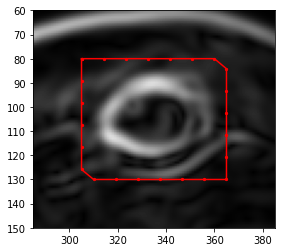

In [ ]:
# resample the curve using the np.interp function to have 25 points
# (use the dist array as the x-coordinates)
# the y-coordinates are the first and second columns of the curve array
curve_resampled = resampleCurveUniform(curve, 25)

# show the image with the resampled curve with points (use plt.scatter and plt.plot for the curve)
plt.imshow(mag, cmap='gray')
plt.scatter(curve_resampled[:,0], curve_resampled[:,1], c='r', s=5)
plt.plot(curve_resampled[:,0], curve_resampled[:,1], 'r-')
# crop the figure to the bounding box of the curve
plt.xlim(curve_resampled[:,0].min() - 20, curve_resampled[:,0].max() + 20)
plt.ylim(curve_resampled[:,1].max() + 20, curve_resampled[:,1].min() - 20)

In [ ]:
# this function calculates the energy function for a window around a point
# the first term is the gradient magnitude at the point and the second term is the 
# elasticity term (alpha * first curve derivative + beta * second curve derivative)
def calculateWindowEnergyFunction(
    point, next_point, prev_point, 
    gradient_image_,
    window_size=3, 
    alpha=0.05,
    beta=0.05
    ):

    # half the window size (integer division)
    W = window_size // 2

    # TODO: your code here...
    (x,y) = point
    (x,y)= (int(x),int(y))
    # get a patch of size WxW around the point of the gradient_image_ array
    # use the point variable, point = (x, y), so the patch is gradient_image_[y-W/2:y+W/2+1, x-W/2:x+W/2+1]
    patch = mag[y-W:y+W+1, x-W:x+W+1]
    #print(patch.shape)
    #print(patch)
    # normalize the patch to the range [0, 1] with cv2.normalize and cv2.NORM_MINMAX
    patch = cv2.normalize(patch, 0, 1, cv2.NORM_MINMAX)
    #print(patch)
#
    # for each point in the window, calculate the first derivative in terms of the curve
    # e.g. the distance between the point and the next point in the curve
    # as well as the second derivative in terms of the curve, which is the difference 
    # in distance between the point and the next point, and the point and the previous point
    # use the alpha and beta parameters to weight the two terms
    # do this for every point in the window/patch
    elasticity_term_energy = np.zeros_like(patch)
    for y in range(patch.shape[0]):
        for x in range(patch.shape[1]):
            #alpha * first + beta * second
            # calculate the global coordinates of the point in the window
            # use the np.array function to create an array from the x and y coordinates
            # subtract the window half size, and add the point coordinates
            global_point = (point[0]-W+x, point[1]-W+y)
            #print(window_point_global_coordinates)
            # calculate the energy term for the point in the window
            # use the np.linalg.norm function to calculate the squared euclidean distance
            # the first derivative is the distance between the point and the next point
            # the second derivative is the difference in distances
            # don't forget to multiply the two terms with the alpha and beta parameters
            first_dir = np.linalg.norm(next_point - global_point, ord=2)
            second_dir = first_dir - np.linalg.norm(prev_point - global_point, ord=2)
            elasticity_term_energy[y, x] =  first_dir * alpha + second_dir * beta
                
    # normalize the energy term to the range [0, 1] for good measure
    elasticity_term_energy = cv2.normalize(elasticity_term_energy, 0, 1, cv2.NORM_MINMAX)
    #elasticity_term_energy/np.mean(elasticity_term_energy)
    # add the weighted distance to the patch, negate it because we want to find a maximum
    patch += -elasticity_term_energy 
    #print(elasticity_term_energy)
    return patch
#i=3
#patch = calculateWindowEnergyFunction(
#            curve[i], 
#            curve[(i+1)%curve.shape[0]], 
#            curve[(i-1)], 
#            mag)
#print(patch)

def findMaximumInPatch(patch, point):
    # find the maximum value in the patch with np.max
    # and return the coordinates of the maximum value
    max_value_in_patch = np.max(patch)
    # find the point of the maximal gradient magnitude in the window using np.argwhere
    # add the offset of the window to the point of the maximal gradient magnitude
    # np.argwhere returns an array of shape (1, 2), so we need to take the first element
    max_gradient_magnitude_index = np.argwhere(max_value_in_patch==patch)
    #print(max_gradient_magnitude_index[0])
    #print(patch)
    #print(max_gradient_magnitude_index)
    #print(patch-max_value_in_patch)
    # offset the patch coordinates to the global coordinates of the image
    # subtract the window half size (patch.shape[0] // 2), and add the point coordinates
    #print(max_gradient_magnitude_index[0][0])
    max_idx = np.array([max_gradient_magnitude_index[0][1] - (patch.shape[0] // 2) + point[0], 
                max_gradient_magnitude_index[0][0] - (patch.shape[1] // 2) + point[1]])
    return max_idx


#plt.figure(figsize=(15,15))
#print(patch)
#plt.imshow(patch, cmap='gray')
#max_idx = findMaximumInPatch(patch,curve[i])
#plt.scatter(max_idx[1], max_idx[0], c='r', s=10)


In [ ]:
# calculate the energy function for the all points in the curve
# use the calculateWindowEnergyFunction function
# and display the patches with the maximum value in the patch (use plt.imshow) in a grid
# (use plt.subplot)
# use the findMaximumInPatch function to find the maximum value in the patch
# and display the maximum value in the patch with a red dot (use plt.scatter)
def showEnergyFunctionPatches(curve_, mag_, window_size=20, alpha=0.05, beta=0.05):
    plt.figure(figsize=(15,15))
    for i in range(curve_.shape[0]):
        patch = calculateWindowEnergyFunction(
            curve_[i], 
            curve_[(i+1)%curve_.shape[0]], 
            curve_[(i-1)], 
            mag_, 
            window_size=window_size,
            alpha=alpha,
            beta=beta)
        plt.subplot(5, 5, i+1)
        plt.imshow(patch, cmap='gray')
        plt.axis('off')
        w2 = patch.shape[0] // 2
        max_idx = findMaximumInPatch(patch, curve_[i]) + w2 - curve_[i]
        
        # show an arrow from the center of the patch to the maximum value in the patch
        plt.arrow(w2, w2, max_idx[0]-w2, max_idx[1]-w2, color='b', head_width=1, head_length=1)
        plt.scatter(max_idx[0], max_idx[1], c='r', s=10)
        # in the title, show the index of the point in the curve and the norm of the vector
        # from the center of the patch to the maximum value in the patch
        plt.title('Point %d (%.2f)' % (i, np.linalg.norm(max_idx - w2)))
    plt.tight_layout()

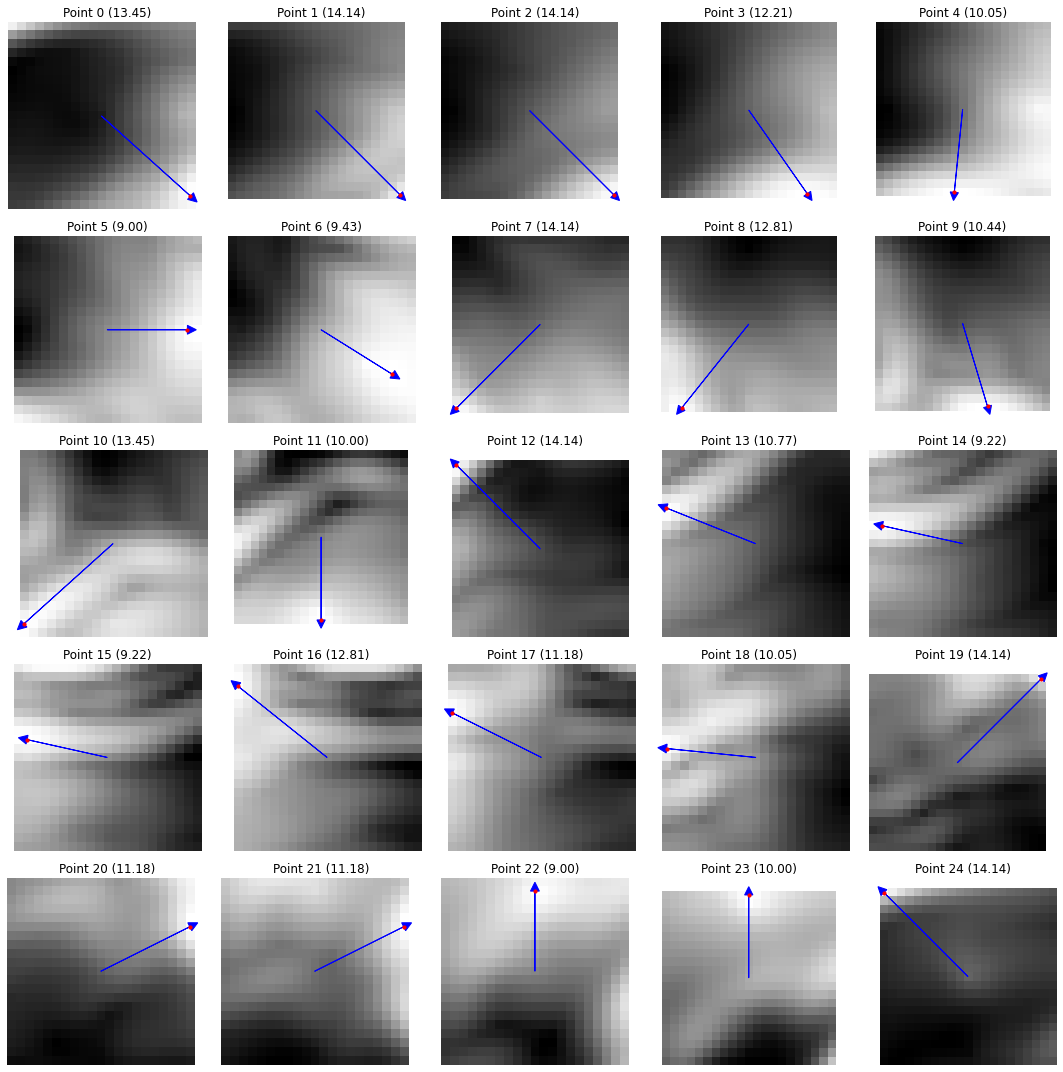

In [ ]:
showEnergyFunctionPatches(curve_resampled, mag, window_size=20, alpha=0.01, beta=0.08)

In [ ]:
def updateCurve(curve, gradient_image_, window_size=20, alpha=0.05, beta=0.05):
    # for each point in the curve, calculate the energy function
    # and find the maximum value in the patch
    # use the calculateWindowEnergyFunction function
    # and the findMaximumInPatch function
    # update the curve with the new point
    # return the new curve
    new_curve = np.zeros_like(curve)

    # implement the update of the curve

    for i in range(curve.shape[0]):
        patch = calculateWindowEnergyFunction(
            curve[i],
            curve[(i+1)%curve.shape[0]], 
            curve[i-1], 
            gradient_image_, 
            window_size=window_size,
            alpha=alpha,
            beta=beta)

        max_idx = findMaximumInPatch(patch,curve[i])

        # advance the curve by 2 pixels in the direction of the maximal point
        # find the direction of the maximal point using a normalized vector
        # add the direction vector to the current point
        # the direction vector is the difference between the current point (curve[i]) and the maximal point (max_idx)
        # use the np.linalg.norm function to calculate the squared euclidean distance
        direction = max_idx - curve[i]
        #print(direction)
        direction_norm = cv2.normalize(direction, 0, 1)
        direction_distance = np.linalg.norm(direction_norm, ord=2)
        #print(direction_norm)
        #print(curve[i])
        if direction_distance > 0:
            # if the direction is not close to zero, advance the curve by 2 pixels in the normalized direction of the maximal point
            new_curve[i] = curve[i] + 2 * direction_norm.T
        else:
            # if the direction is close to zero, use the current point
            new_curve[i] = curve[i]

    return new_curve

<ipython-input-274-cdf7b499a18f>:14: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(5,5))


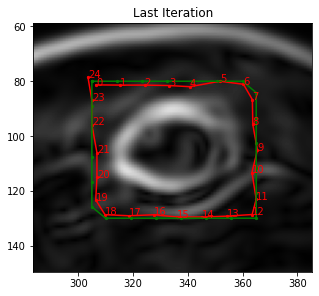

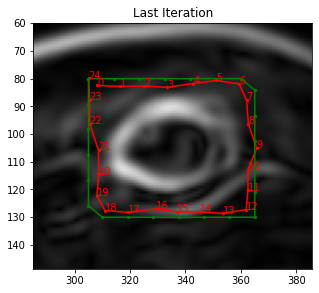

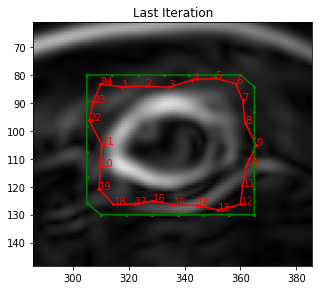

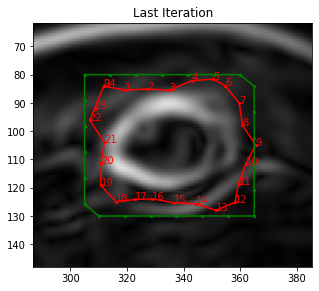

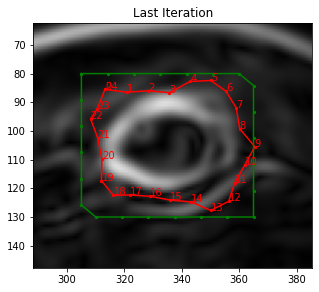

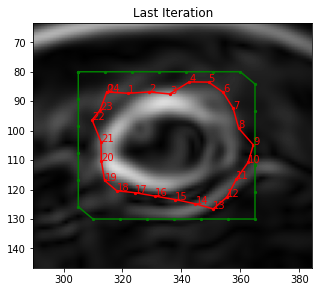

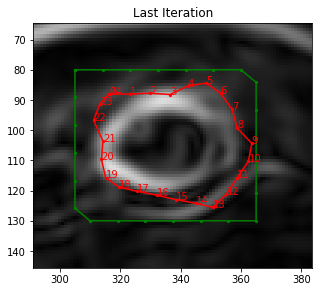

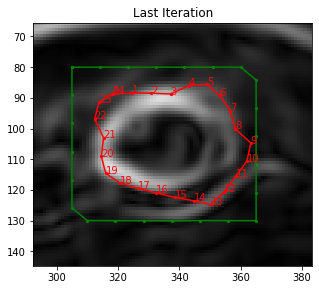

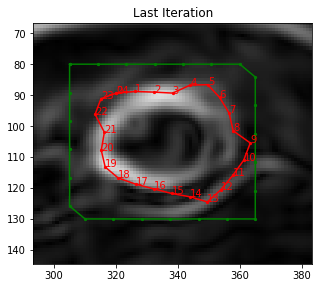

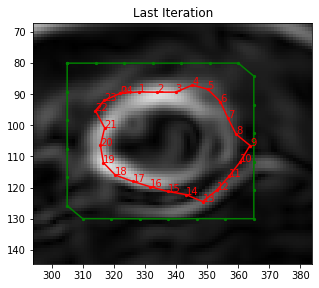

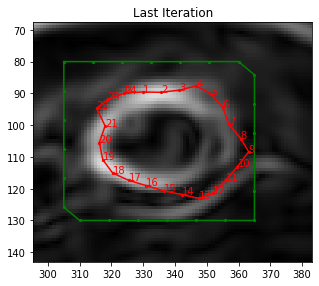

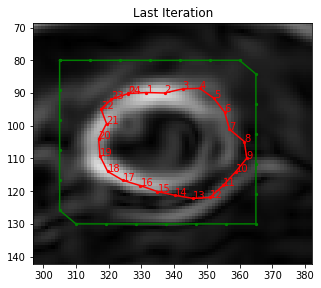

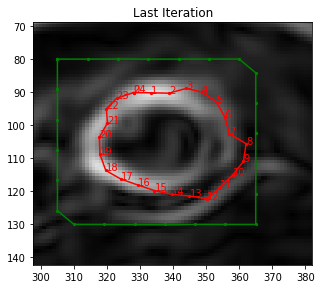

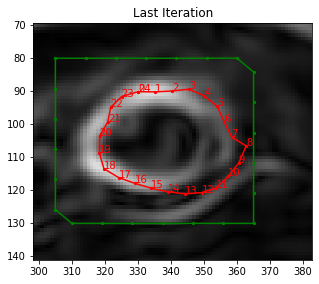

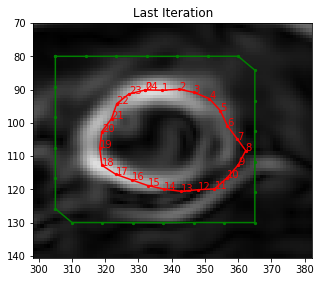

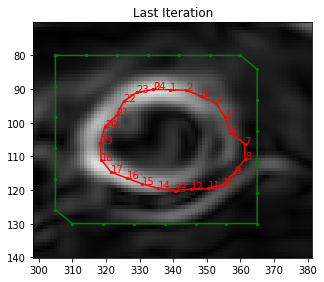

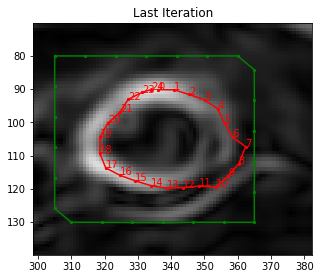

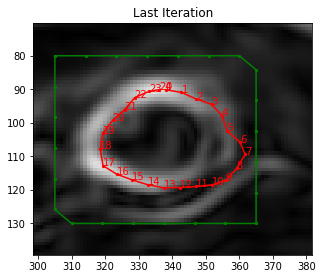

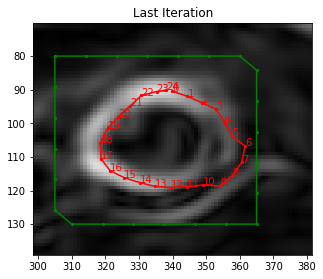

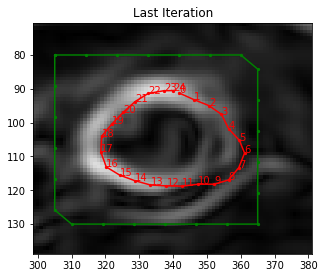

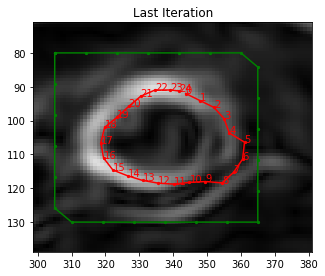

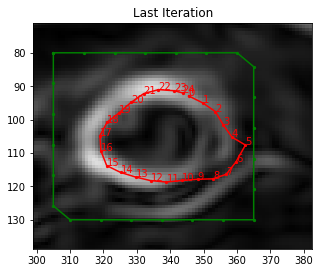

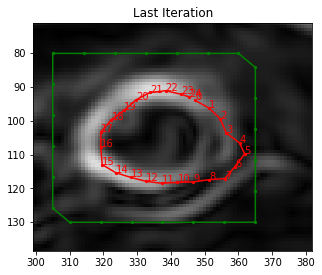

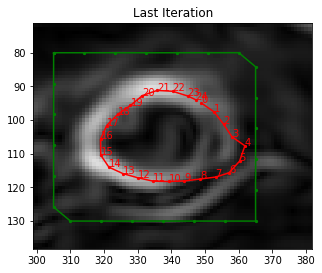

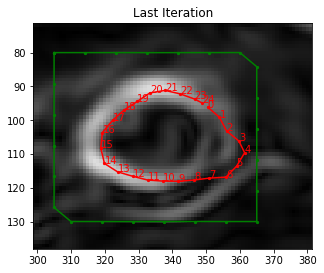

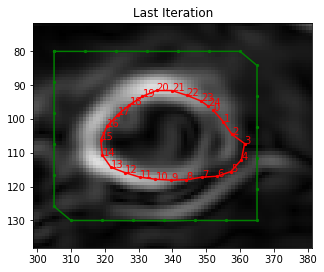

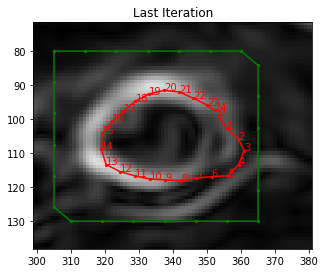

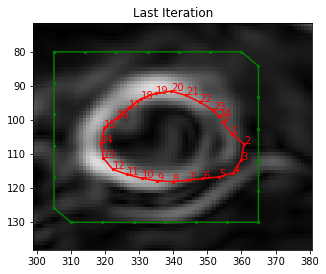

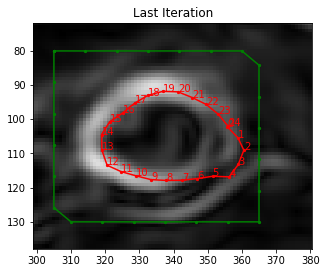

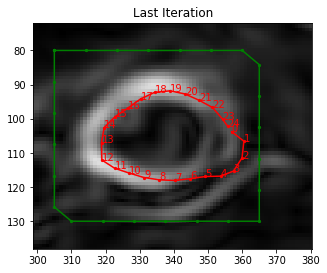

In [ ]:

# update the curve a few times
# display the updated curve on the gradient image
new_curve = curve_resampled
for i in range(30):
    # set the last point to the first point
    new_curve[-1] = new_curve[0]
    # resample the curve to a uniform distance using the resampleCurve function
    new_curve = resampleCurveUniform(new_curve)
    # update the curve using the updateCurve function
    # use the alpha and beta parameters to weight the two terms
    # use the window_size parameter to set the size of the window
    # the parameters that worked for me are window_size=20, alpha=0.01, beta=0.08
    new_curve = updateCurve(new_curve,mag,window_size=20, alpha=0.01, beta=0.08)
    plt.figure(figsize=(5,5))
    plt.imshow(mag, cmap='gray')
    plt.plot(new_curve[:,0], new_curve[:,1], c='r')
    plt.scatter(new_curve[:,0], new_curve[:,1], c='r', s=5)
    # show the point index on the image next to the point
    for i in range(new_curve.shape[0]):
        plt.text(new_curve[i,0], new_curve[i,1], str(i), color='r')
    # show the original curve in green
    plt.plot(curve_resampled[:,0], curve_resampled[:,1], c='g')
    plt.scatter(curve_resampled[:,0], curve_resampled[:,1], c='g', s=5)
    plt.title('Last Iteration')
    plt.xlim(new_curve[:,0].min() - 20, new_curve[:,0].max() + 20)
    plt.ylim(new_curve[:,1].max() + 20, new_curve[:,1].min() - 20)

KeyboardInterrupt: 

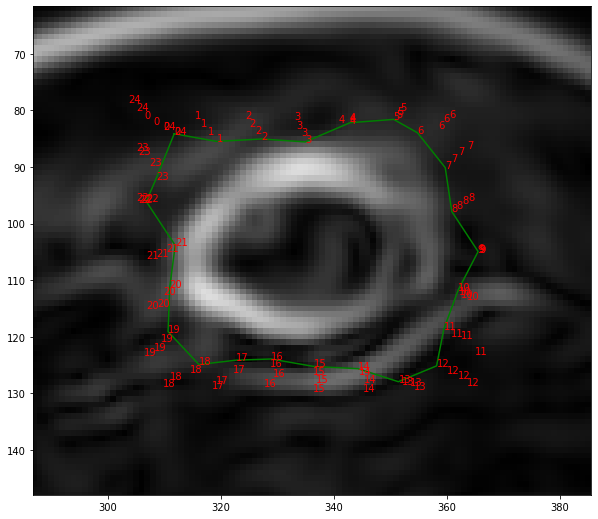

In [ ]:
#WEIRD PLOTTING FUNCTION
# update the curve a few times
# display the updated curve on the gradient image

figure, ax = plt.subplots(figsize=(10, 10))
plt.ion()

new_curve = curve_resampled

line1, = ax.plot(curve_resampled[:,0], curve_resampled[:,1], c='g')
#plt.plot(new_curve[:,0], new_curve[:,1], c='r')

for i in range(30):
    # set the last point to the first point
    new_curve[-1] = new_curve[0]
    # resample the curve to a uniform distance using the resampleCurve function
    new_curve = resampleCurveUniform(new_curve)
    # update the curve using the updateCurve function
    # use the alpha and beta parameters to weight the two terms
    # use the window_size parameter to set the size of the window
    # the parameters that worked for me are window_size=20, alpha=0.01, beta=0.08
    new_curve = updateCurve(new_curve,mag,window_size=20, alpha=0.01, beta=0.08)


    #fig = plt.figure(figsize=(5,5))
    plt.imshow(mag, cmap='gray')
    line1.set_xdata(new_curve[:,0])
    line1.set_ydata(new_curve[:,1])
    figure.canvas.draw()
    #plt.plot(new_curve[:,0], new_curve[:,1], c='r')
    #plt.scatter(new_curve[:,0], new_curve[:,1], c='r', s=5)
    #plt.figure.c
    # show the point index on the image next to the point
    for i in range(new_curve.shape[0]):
        plt.text(new_curve[i,0], new_curve[i,1], str(i), color='r')
    # show the original curve in green
    #plt.plot(curve_resampled[:,0], curve_resampled[:,1], c='g')
    #plt.scatter(curve_resampled[:,0], curve_resampled[:,1], c='g', s=5)
    #plt.title('Last Iteration')
    plt.xlim(new_curve[:,0].min() - 20, new_curve[:,0].max() + 20)
    plt.ylim(new_curve[:,1].max() + 20, new_curve[:,1].min() - 20)
    
 
    # This will run the GUI event
    # loop until all UI events
    # currently waiting have been processed
    figure.canvas.flush_events()
    #time.sleep(0.1)

#anim = animation.FuncAnimation(fig, animate, init_func=init,
                               #frames=200, interval=20, blit=True)

(138.07051852339853, 71.83051302756552)

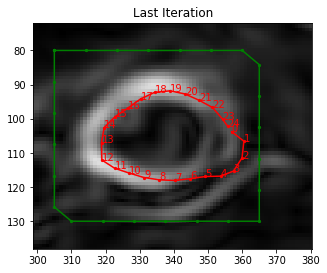

That's a wrap!